In [1]:
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [2]:
# téléchargement du dataset
train_df = pd.read_csv("train.csv")
train_df['datetime'] = pd.to_datetime(train_df['datetime'])

In [3]:
# sélection des features pertinentes
y = train_df[['casual', 'registered', 'count']]

X = train_df.copy()
X["month_id"] = X.datetime.dt.month + 12*(X.datetime.dt.year==2012)
X["hour_id"] = X.datetime.dt.hour
X = X.drop(columns=['season', 'casual', 'registered', 'count'])  


In [4]:
X

,datetime,holiday,workingday,weather,temp,atemp,humidity,windspeed,month_id,hour_id
0,2011-01-01 00:00:00,0,0,1,9.84,14.395,81,0.0000,1,0
1,2011-01-01 01:00:00,0,0,1,9.02,13.635,80,0.0000,1,1
2,2011-01-01 02:00:00,0,0,1,9.02,13.635,80,0.0000,1,2
3,2011-01-01 03:00:00,0,0,1,9.84,14.395,75,0.0000,1,3
4,2011-01-01 04:00:00,0,0,1,9.84,14.395,75,0.0000,1,4
...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,0,1,1,15.58,19.695,50,26.0027,24,19
10882,2012-12-19 20:00:00,0,1,1,14.76,17.425,57,15.0013,24,20
10883,2012-12-19 21:00:00,0,1,1,13.94,15.910,61,15.0013,24,21
10884,2012-12-19 22:00:00,0,1,1,13.94,17.425,61,6.0032,24,22


In [5]:
# sépare les données en un jeu de test et un jeu de train (20% de test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# features numériques
numeric_features = ['temp', 'humidity', 'windspeed', 'atemp']

# features catégoriques destinées à être one-hot encoded
binary_features = ['holiday', 'workingday']
one_hot_features = ['weather', 'month_id', 'hour_id']
categorical_features = binary_features + one_hot_features


In [6]:
# on crée un pipeline qui construit le vecteur input à donner au modèle en entrée

# on normalise les valeurs numériques
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  
])

# on laisse les features binaires inchangées
binary_transformer = 'passthrough'

# on transforme en one hot les features catégoriques
one_hot_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode the categorical features
])

# on combine les pipelines pour les données numériques et catégoriques
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('bin', binary_transformer, binary_features),
        ('one_hot', one_hot_transformer, one_hot_features)
    ])

clf = Pipeline(steps=[('preprocessor', preprocessor)])
clf.fit(X_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['temp', 'humidity',
                                                   'windspeed', 'atemp']),
                                                 ('bin', 'passthrough',
                                                  ['holiday', 'workingday']),
                                                 ('one_hot',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['weather', 'month_id',
                                                   'hour_id'])]))])

In [7]:
# on transforme les données avec la pipeline puis on les met sous la forme de torch.tensor pour le modèle
Xtr_tensor = torch.tensor(clf.transform(X_train).toarray(), dtype=torch.float32)
ytr_tensor = torch.tensor(y_train.values/500.0, dtype=torch.float32)

Xtest_tensor = torch.tensor(clf.transform(X_test).toarray(), dtype=torch.float32)
ytest_tensor = torch.tensor(y_test.values/500.0, dtype=torch.float32)

# on crée un DataLoader afin de charger plus facilement les données d'entraînement lors de l'apprentissage du modèle
train_dataset = TensorDataset(Xtr_tensor, ytr_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [8]:
class MLP(nn.Module):

    def __init__(self, input_size, output_size, hidden_size):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.ReLU()
        )

    def forward(self, x):
        output = self.mlp(x)
        return output

In [9]:
def RMLSE(output, target):
    log_diff = torch.log(output+1) - torch.log(target+1)
    return torch.sqrt(torch.mean(log_diff**2))

step: 0 | train_loss: 3.1462 | test_loss: 3.1045
step: 100 | train_loss: 0.8913 | test_loss: 0.8006
step: 200 | train_loss: 0.6230 | test_loss: 0.5886
step: 300 | train_loss: 0.4741 | test_loss: 0.4897
step: 400 | train_loss: 0.3934 | test_loss: 0.4541
step: 500 | train_loss: 0.3864 | test_loss: 0.4304
step: 600 | train_loss: 0.4086 | test_loss: 0.4421
step: 700 | train_loss: 0.3112 | test_loss: 0.4321
step: 800 | train_loss: 0.4008 | test_loss: 0.4206
step: 900 | train_loss: 0.4131 | test_loss: 0.4190
step: 1000 | train_loss: 0.3703 | test_loss: 0.4181
step: 1100 | train_loss: 0.3377 | test_loss: 0.4192
step: 1200 | train_loss: 0.3876 | test_loss: 0.4257
step: 1300 | train_loss: 0.3331 | test_loss: 0.4286
step: 1400 | train_loss: 0.3115 | test_loss: 0.4313


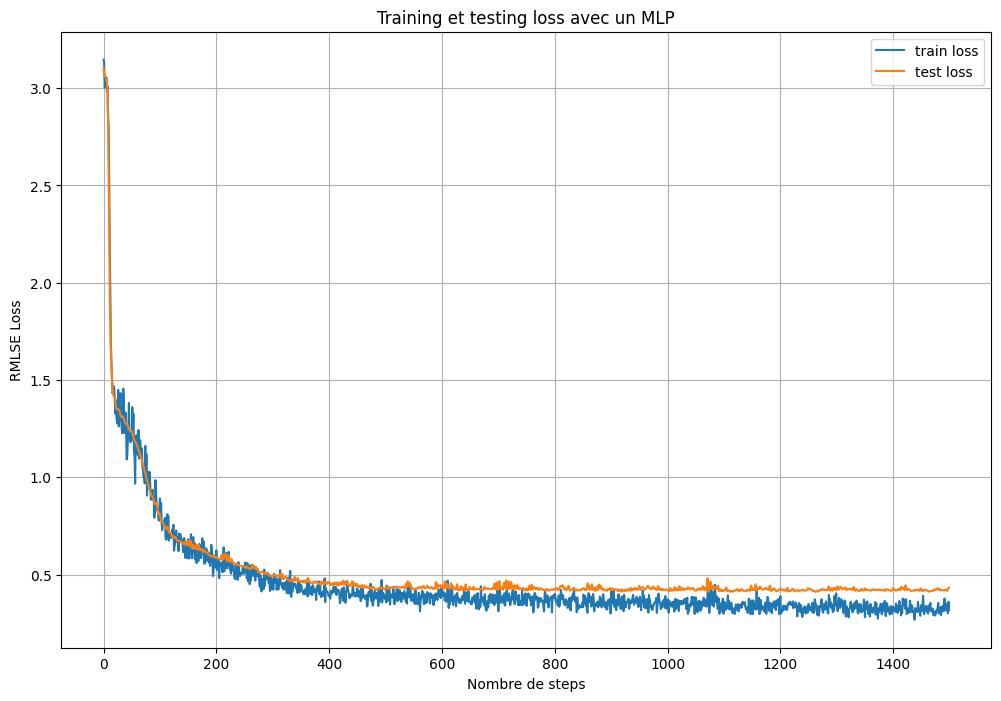

In [18]:
nb_steps = 1500 # nombre de steps d'entraînement
model = MLP(input_size=Xtr_tensor.shape[-1], output_size=ytr_tensor.shape[-1], hidden_size=60)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
train_losses = []
test_losses = []

# boucle d'entraînement du modèle
for step in range(nb_steps):
    inputs, targets = next(iter(train_loader))

    optimizer.zero_grad()
    outputs = model(inputs) # calcule les prédictions du modèle
    loss = RMLSE(500.0*outputs, 500.0*targets)
    loss.backward() # calcule le gradient de la loss par rapport aux paramètres
    optimizer.step() # met à jour les paraùètres
    train_losses.append(loss.item())

    # calcule la loss sur le jeu de test pour évaluer la généralisabilité du modèle
    with torch.no_grad():
        test_outputs = model(Xtest_tensor)
        # test_loss = torch.mean((test_outputs-ytest_tensor)**2)
        test_loss = RMLSE(500.0*test_outputs, 500.0*ytest_tensor)
        test_losses.append(test_loss.item())

    if step%100 == 0:
        print(f"step: {step} | train_loss: {loss.item():.4f} | test_loss: {test_loss.item():.4f}")

# affiche la figure
plt.figure(figsize=(12,8))
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.xlabel("Nombre de steps")
plt.ylabel("RMLSE Loss")
plt.title("Training et testing loss avec un MLP")
plt.legend()
plt.grid()
plt.show()

In [11]:
# téléchargement du dataset
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df['dataset'] = 'train'
test_df['dataset'] = 'test'

# réunion des deux DataFrames
combined_df = pd.concat([train_df, test_df], ignore_index=True)
combined_df['datetime'] = pd.to_datetime(combined_df['datetime'])
combined_df.sort_values(by="datetime", inplace=True)

In [14]:
# sélection des features pertinentes
X = combined_df.drop(columns=['season', 'casual', 'registered', 'count'])  
X["month_id"] = X.datetime.dt.month + 12*(X.datetime.dt.year==2012)
X["hour_id"] = X.datetime.dt.hour
X_tensor = torch.tensor(clf.transform(X).toarray(), dtype=torch.float32)
X_tensor.shape
outputs = model(X_tensor)[:, 2]*500.0

[]

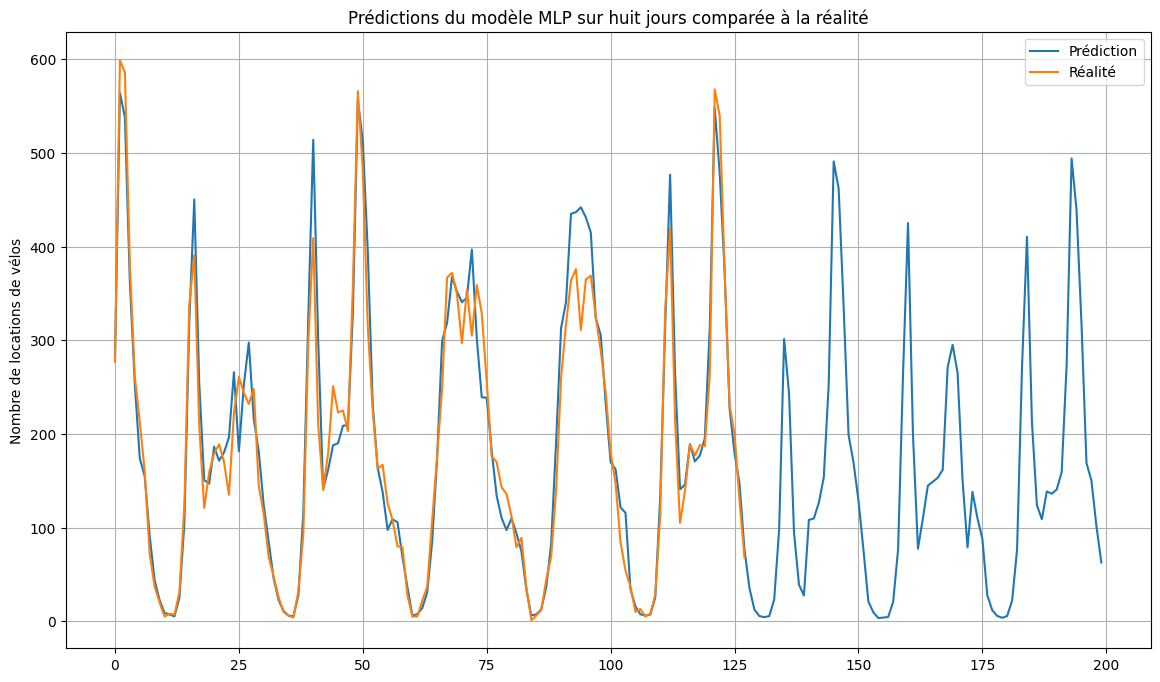

In [16]:
debut = 6050
nb_values = 200
plt.figure(figsize=(14,8))
plt.plot(outputs[debut:debut+200].tolist(), label="Prédiction")
plt.plot(combined_df['count'][debut:debut+200].tolist(), label="Réalité")
plt.grid()
plt.ylabel("Nombre de locations de vélos")
plt.legend()
plt.title('Prédictions du modèle MLP sur huit jours comparée à la réalité')
plt.plot()

In [34]:
def get_submission(model, title):
    test_df = pd.read_csv("test.csv")
    test_df['datetime'] = pd.to_datetime(test_df['datetime'])
    X = test_df.drop(columns=['season'])  
    X["month_id"] = X.datetime.dt.month + 12*(X.datetime.dt.year==2012)
    X["hour_id"] = X.datetime.dt.hour
    X_tensor = torch.tensor(clf.transform(X).toarray(), dtype=torch.float32)

    predictions = model(X_tensor)[:,2]*500.0
    predictions.shape

    submission_df = X.copy()
    submission_df.drop(columns=['holiday', 'workingday', 'weather', 'temp', 'humidity',
        'windspeed', 'month_id', 'hour_id', 'atemp'], inplace=True)
    submission_df["count"] = torch.relu(predictions).tolist()
    submission_df.to_csv(f"submission_{title}.csv", index=False)

In [35]:
# 2581/3243 et score de 0.744 avec la loss MSE
# 1250/3243 et score de 0.481 avec la loss RMLSE
# 940/3243 et score de 0.46 avec des petites optimisations

In [36]:
get_submission(model=model, title="mlp-rmlse") 